# Transformer Models Tutorial
This tutorial concerns following questions:
1. How to apply SASRec and BERT4Rec transformer models using RecTools?
2. How does SASRec and BERT4Rec work under the hood?

Transformer models came to recommendation systems from NLP, where they proved to have a significant impact. As transformers were applied to sequential data it is common to use them for session-based recommendations, where interactions are ordered by the date of their occurrence. In this tutorial focus is on SASRec and BERT4Rec - models which are considered as a common starting point for transformer application in recsys. Due to the fact that transformers base on attention mechanism, they have some advantages compared to RNN, LSTM and CNN:
1. Unlike other sequence-based architectures(RNN and LSTM), transformers do not struggle with long-range dependencies
2. Transformers have better scalability, because of process parallelization

### Why transformers from RecTools?
RecTools library offers efficient and well-performing implementation of SASRec and BERT4Rec. It has easy-to-use interface and provides user with a flexibility to customize models by replacing transformer model blocks.

### Table of Contents

* Prepare data
* SASRec & BERT4Rec
    * SASRec
    * BERT4Rec
    * Main differences
* RecTools implementation 
* Application of models
    * Basic usage
    * Adding item features to models
    * Selecting losses
    * Customizing model 
    * Cross-validation
    * Item-to-item recommendations
    * Inference tricks (inference for cold users)
* Detailed SASRec and BERT4Rec description
    * Dataset processing
    * Transformer layers
    * Losses
* Links

In [17]:
import numpy as np
import os
import pandas as pd
import torch
import typing as tp
import warnings

from lightning_fabric import seed_everything
from pathlib import Path

from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import (
    MAP,
    CoveredUsers,
    AvgRecPopularity,
    Intersection,
    HitRate,
    Serendipity,
)
from rectools.models import PopularModel, EASEModel, SASRecModel, BERT4RecModel
from rectools.model_selection import TimeRangeSplitter, cross_validate
from rectools.models.nn.item_net import CatFeaturesItemNet, IdEmbeddingsItemNet
from rectools.visuals import MetricsApp

# Enable deterministic behaviour with CUDA >= 10.2
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
warnings.simplefilter("ignore", UserWarning)

# Prepare data

We are using KION dataset for this tutorial. The data was gathered from the users of MTS KION video streaming platform.

In [3]:
%%time
!wget -q https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_en.zip -O data_en.zip
!unzip -o data_en.zip
!rm data_en.zip

Archive:  data_en.zip
  inflating: data_en/items_en.csv    
  inflating: __MACOSX/data_en/._items_en.csv  
  inflating: data_en/interactions.csv  
  inflating: __MACOSX/data_en/._interactions.csv  
  inflating: data_en/users_en.csv    
  inflating: __MACOSX/data_en/._users_en.csv  
CPU times: user 165 ms, sys: 73 ms, total: 238 ms
Wall time: 10.7 s


In [4]:
# Download dataset
DATA_PATH = Path("data_en")
items = pd.read_csv(DATA_PATH / 'items_en.csv', index_col=0)
interactions = (
    pd.read_csv(DATA_PATH / 'interactions.csv', parse_dates=["last_watch_dt"])
    .rename(columns={"last_watch_dt": Columns.Datetime})
)
print(interactions.shape)
interactions.head(2)

(5476251, 5)


,user_id,item_id,datetime,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0


In [5]:
# Process interactions
interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 10, 3, 1)
interactions = interactions[["user_id", "item_id", "datetime", "weight"]]
print(interactions.shape)
interactions.head(2)

(5476251, 4)


,user_id,item_id,datetime,weight
0,176549,9506,2021-05-11,3
1,699317,1659,2021-05-29,3


In [6]:
print(items.shape)
items.head(2)

(15963, 16)


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,description,keywords,actors_translated,actors_transliterated,directors_translated,transliterated
0,10711,film,Talk to her,Hable con ella,2002.0,"drama, foreign, detective, melodrama",Spain,NaN,16.0,NaN,"Marco, a journalist, interviews the famous Tor...","Talk, her, 2002, Spain, friends, love, strong,...","Adolfo Fernández, Ana Fernández, Dario Grandin...","Adol'fo Fernandes, Ana Fernandes, Dario Grandi...",Pedro Almodovar,Pedro Al'modovar
1,2508,film,Naked Peppers,Search Party,2014.0,"foreign, adventure, comedy",USA,NaN,16.0,NaN,The main character has learned not to invite h...,"Naked, Peppers, 2014, USA, friends, weddings, ...","Adam Palley, Brian Huskey, JB Smoove, Jason Ma...","Adam Palli, Brajan Haski, Dzh.B. Smuv, Dzhejso...",Scott Armstrong,Skot Armstrong


In [7]:
# Process item features
items = items.loc[items[Columns.Item].isin(interactions[Columns.Item])].copy()
items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
content_feature = items.reindex(columns=[Columns.Item, "content_type"])
content_feature.columns = ["id", "value"]
content_feature["feature"] = "content_type"
item_features = pd.concat((genre_feature, content_feature))

In [8]:
item_features.head()

,id,value,feature
0,10711,drama,genre
0,10711,foreign,genre
0,10711,detective,genre
0,10711,melodrama,genre
1,2508,foreign,genre


In [9]:
# Create datasets
dataset_no_features = Dataset.construct(
    interactions_df=interactions,
)

dataset_item_features = Dataset.construct(
    interactions_df=interactions,
    item_features_df=item_features,
    cat_item_features=["genre", "content_type"],
)

In [10]:
# Prepare test user
test_user = [176549] 
print(interactions[interactions["user_id"] == test_user[0]].shape)
interactions[interactions["user_id"] == test_user[0]].head(2)

(82, 4)


,user_id,item_id,datetime,weight
0,176549,9506,2021-05-11,3
3815,176549,15469,2021-05-25,3


In [11]:
# Prepare test item
test_item = [13865]

In [88]:
RANDOM_STATE=60
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)

# SASRec & BERT4Rec

## SASRec
SASRec is a transformer-based sequential model with <b>unidirectional</b> attention mechanism and <b>"Shifted Sequence"</b> training objective. 

As an input SASRec takes user sequences, containing previous user interaction history. Description of how they are created from user-item interactions can be found in the "Detailed SASRec and BERT4Rec description" part. Item embeddings from these sequences are fed to transformer blocks with multi-head self-attention and feedforward neural network as main components. After one or several stacked attention blocks, resulting user sequence latent representation is used to predict all items in the sequence. Each item prediction bases only on previous item information.


## BERT4Rec
BERT4Rec is a transformer-based sequential model with <b>bi-directional</b> attention mechanism and <b>"Item Masking"</b> training objective.

As an input BERT4Rec receives user sequences, containing previous user interaction history. Description of how they are created from user-item interactions can be found in "Detailed SASRec and BERT4Rec description" part. Item embeddings from these sequences are fed to transformer blocks with multi-head self-attention and feedforward neural network as main components.  After one or several stacked attention blocks, resulting user sequence latent representation is used to predict masked items.

## Main Differences

<table>
    <tr>
        <th>Difference</th>
        <th>Difference type</th>
        <th> SASRec </th>
        <th>BERT4Rec</th> 
    </tr>
    <tr>
        <td>Target</td>
        <td>Conceptual</td>
        <td>Shiftes sequence target</td>
        <td>Item masking target</td>
    </tr>
    <tr>
        <td>Attention</td>
        <td>Conceptual</td>
        <td>Uni-directional</td>
        <td>Bi-directioinal</td>
    </tr>
        <tr>
        <td>Transformer block structure</td>
        <td>Can be modified</td>
        <td>Check "Detailed SASRec and BERT4Rec description" to see block structure</td>
        <td>Check "Detailed SASRec and BERT4Rec description" to see block structure</td>
    </tr>
        <tr>
        <td>Activation function</td>
        <td>Can be modified</td>
        <td>ReLU</td>
        <td>GELU</td>
    </tr>
    <tr>
        <td>Loss</td>
        <td>Can be modified</td>
        <td>BCE with 1 negative per positive</td>
        <td>Softmax</td>
    </tr>
</table>

Following pictures provide more insights into attention difference:

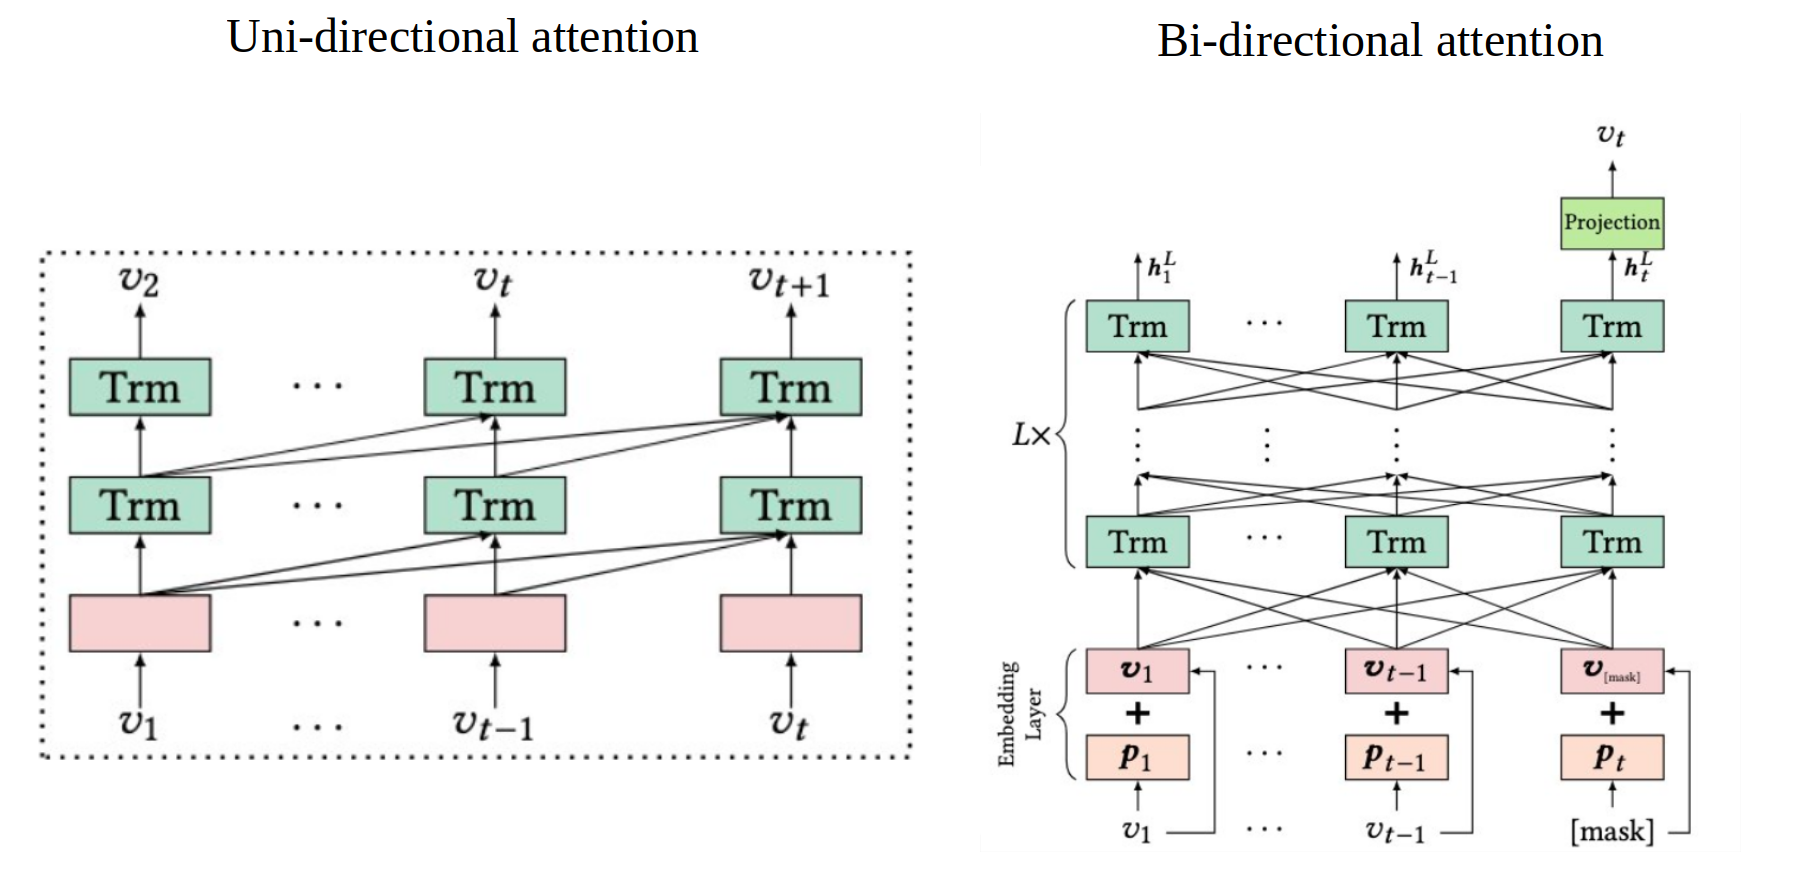

# RecTools implementation


<table>
    <tr>
        <th> Losses</th>
        <th> SASRec </th>
        <th>BERT4Rec</th> 
    </tr>
    <tr>
        <td>Softmax loss</td>
        <td>+</td>
        <td>+</td>
    </tr>
        <tr>
        <td>BCE loss</td>
        <td>+</td>
        <td>+</td>
    </tr>
        <tr>
        <td>gBCE loss</td>
        <td>+</td>
        <td>+</td>
    </tr>
</table>

<table>
    <tr>
        <th> Cusomization options</th>
        <th> SASRec </th>
        <th>BERT4Rec</th> 
    </tr>
    <tr>
        <td>Data preprocessing</td>
        <td>+</td>
        <td>+</td>
    </tr>
    <tr>
        <td>Item embeddings</td>
        <td>+</td>
        <td>+</td>
    </tr>
        <tr>
        <td>Positional encoding</td>
        <td>+</td>
        <td>+</td>
    </tr>
        <tr>
        <td>Transformer layers</td>
        <td>+</td>
        <td>+</td>
    </tr>
        <tr>
        <td>Model training</td>
        <td>+</td>
        <td>+</td>
</table>

\* customization options describe what parts of transformer model architecture can be changed by the user flexibly. For that user should inherit from the respective base class and pass a new class as a model parameter.

## Reference implementations 

1. BERT4Rec reference implementation: https://github.com/jaywonchung/BERT4Rec-VAE-Pytorch.git
2. In addition to original model losses implemented gBCE loss with uniform negative sampling and number of negatives as a hyper-parameter: https://github.com/asash/gSASRec-pytorch.git



# Application of Models
## Basic usage


* Specify maximum length of user-item interaction history with `session_max_len`
* Specify `loss` from "softmax", "BCE", "gBCE"
* Specify latent embeddings size with `n_factors`
* Specify number of self-attention blocks with `n_blocks` 
* Specify number of attention heads with `n_heads`
* Specify `dropout_rate`
* Specify `lr` for learning rate 
* Specify `batch_size`
* Specify `dataloader_num_workers`
* Specify `cpu_n_threads`
* Specify `verbose`
* Specify `epochs` for number of model training epochs

Parameter specific for BERT4Rec:
* Specify probability of a sequence item to be masked `mask_prob` 

In [87]:
sasrec_non_default_model = SASRecModel(
    n_factors=128, 
    n_blocks=2,
    n_heads=1,
    dropout_rate=0.2,
    use_pos_emb=True,
    session_max_len=32,
    lr=1e-3,
    batch_size=128,
    epochs=5,
    loss="softmax",
    verbose=1,
    deterministic=True,
    item_net_block_types=(IdEmbeddingsItemNet, )  # Use only item ids in ItemNetBlock
)

bert4rec_id_softmax_model = BERT4RecModel(
    mask_prob=0.5,
    item_net_block_types=(IdEmbeddingsItemNet, ),
)

In [84]:
%%time
sasrec_non_default_model.fit(dataset_no_features)

In [17]:
%%time
recos = sasrec_non_default_model.recommend(
    users=test_user, 
    dataset=dataset_no_features,
    k=3,
    filter_viewed=True,
    on_unsupported_targets="warn"
)
recos.merge(items[["item_id", "title_orig"]], on="item_id").sort_values(["user_id", "rank"])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/data/home/maspirina1/tasks/repo/RecTools/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=143` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

CPU times: user 733 ms, sys: 1.84 s, total: 2.57 s
Wall time: 668 ms


,user_id,item_id,score,rank,title_orig
0,176549,12965,2.710880,1,Cars 3
1,176549,11749,2.549064,2,Incredibles 2
2,176549,7310,2.495675,3,Despicable Me 2


## Adding item features to models

<b>Categorical features:</b>

For each pair of feature and feature value categorical feature embedding is created. Categorical feature embeddings are summed up with other embeddings for each item if they are present in the model.

<b>Numerical features:</b>

Are not supported.


To add item features it is necessary to pass them to RecTools dataset and add CatFeaturesItemNet to item_net_block_types. Any combination of IdEmbeddingsItemNet and CatFeaturesItemNet is applicable.

In [83]:
sasrec_id_softmax_model = SASRecModel(
    item_net_block_types=(IdEmbeddingsItemNet,)  # Use item ids and cat features in ItemNetBlock
)
sasrec_id_cat_softmax_model = SASRecModel(
    item_net_block_types=(IdEmbeddingsItemNet, CatFeaturesItemNet)  # Use item ids and cat features in ItemNetBlock
)
sasrec_cat_softmax_model = SASRecModel(
    item_net_block_types=(CatFeaturesItemNet, )  # Use only cat item features in ItemNetBlock
)

## Selecting losses 

RecTools supports 3 losses:

1. Softmax: requires no additional parameters
2. BCE: user can specify number of negatives to be sampled
3. gBCE: user can specify number of negatives to be sampled and calibration hyperparameter

In [82]:
softmax_model_example = SASRecModel(
    loss="softmax",
)
sascrec_id_cat_bce_model = SASRecModel(
    loss="BCE",
    n_negatives=15,
)
sasrec_id_cat_gbce_model = SASRecModel(
    loss="gBCE",
    n_negatives=15,
    gbce_t=0.2,
)

## Customizing model 

* Specify minimum number of user interactions in train dataset with `train_min_user_interaction`
* Specify whether positional encoding should be used with `use_pos_emb`
* Specify lightning trainer with `trainer`

For custom classes: inherit from base class and pass custom class as model parameter
* Specify `item_net_block_types` for Item Net blocks from (IdEmbeddingsItemNet, CatFeaturesItemNet), (IdEmbeddingsItemNet,),            (, CatFeaturesItemNet) or custom embedding network. Inherit from `ItemNetBase`
* Specify `pos_encoding_type` for custom positional encoding logic. Inherit from `PositionalEncodingBase`
* Specify `transformer_layers_type` for custom transformer layers logic. Inherit from `TransformerLayersBase`
* Specify `data_preparator_type` for custom data processing logic. Inherit from `SessionEncoderDataPreparatorBase`
* Specify `lightning_module_type` for custom training logic. Inherit from `SessionEncoderLightningModuleBase`

# Cross-validation

In [20]:
# Use last week to validate model. Number of folds is set to 1 to speed up training
splitter = TimeRangeSplitter(
    test_size="7D",
    n_splits=1,
    filter_already_seen=True,
)

In [81]:
# Add PopularModel and EASEModel to compare performance of transformer models
models = {
    "popular": PopularModel(),
    "ease": EASEModel(),
    "sasrec_non_default": sasrec_non_default_model,
    "sasrec_id_softmax": sasrec_id_softmax_model,
    "sasrec_cat_softmax": sasrec_cat_softmax_model,
    "sasrec_id_cat_softmax": sasrec_id_cat_softmax_model,
    "sascrec_id_cat_bce": sascrec_id_cat_bce_model,
    "sasrec_id_cat_gbce": sasrec_id_cat_gbce_model,
    "bert4rec_id_softmax": bert4rec_id_softmax_model,
}

metrics = {
    "HitRate@10": HitRate(k=10),
    "MAP@10": MAP(k=10),
    "Serendipity@10": Serendipity(k=10),
    "CoveredUsers@10": CoveredUsers(k=10),
    "AvgRecPopularity@10": AvgRecPopularity(k=10),
    "Intersection@10": Intersection(k=10),
}

K_RECS = 10


In [78]:
# %%time

# For each fold generate train and test part of dataset
# Then fit every model, generate recommendations and calculate metrics

cv_results = cross_validate(
    dataset=dataset_item_features,
    splitter=splitter,
    models=models,
    metrics=metrics,
    k=K_RECS,
    filter_viewed=True,
    ref_models=["popular"],
    validate_ref_models=True,
)

In [77]:
pivot_results = (
    pd.DataFrame(cv_results["metrics"])
    .drop(columns="i_split")
    .groupby(["model"], sort=False)
    .agg(["mean"])
)
pivot_results.columns = pivot_results.columns.droplevel(1)
pivot_results

,HitRate@10,MAP@10,AvgRecPopularity@10,Serendipity@10,Intersection@10_popular,CoveredUsers@10
model,,,,,,
ease,0.152849,0.027214,9707.985821,0.000270,0.081384,1.000000
popular,0.274365,0.080114,82236.761783,0.000002,1.000000,1.000000
sasrec_non_default,0.357389,0.102046,56647.335531,0.000225,0.463671,0.999982
sasrec_id_softmax,0.341564,0.097048,59422.451401,0.000143,0.508318,0.999982
sasrec_cat_softmax,0.037447,0.006898,5458.898310,0.000040,0.020905,0.999982
sasrec_id_cat_softmax,0.353756,0.100961,60493.708599,0.000186,0.519029,0.999982
sascrec_id_cat_bce,0.341718,0.095818,63397.975801,0.000108,0.532142,0.999982
sasrec_id_cat_gbce,0.317571,0.089022,67626.868589,0.000064,0.586153,0.999982
bert4rec_id_softmax,0.309268,0.084099,64674.031090,0.000050,0.602524,0.999982


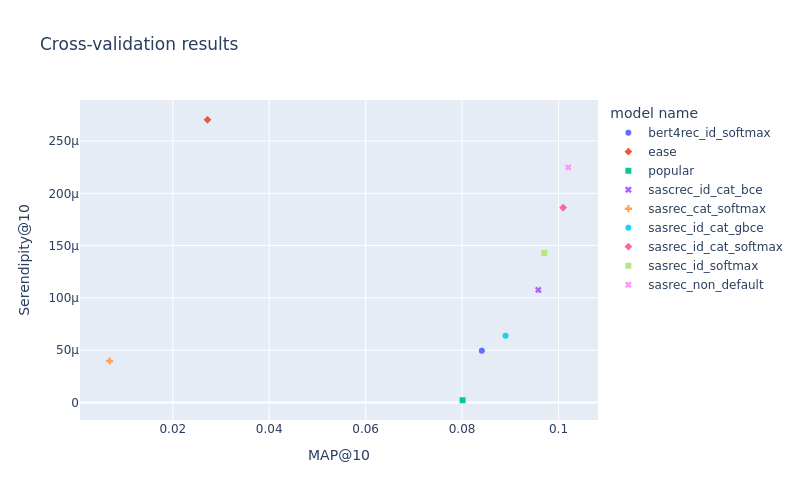

In [9]:
plot_metrics = [{"model": cv_results_dict["model"], "MAP@10": cv_results_dict["MAP@10"], "Serendipity@10": cv_results_dict["Serendipity@10"]} 
                for cv_results_dict in cv_results["metrics"]]
app = MetricsApp.construct(
    models_metrics=pd.DataFrame(plot_metrics),
)
fig = app.fig
fig.update_layout(title="Cross-validation results")
fig.show("png")

## Item-to-item recommendations

i2i recommendations are generated in the following way:
1. Get item embeddings received after the train stage
2. Calculate cosine similarity of item embedding with other item embeddings
3. Return k most similar items

In [24]:
items[items['item_id'] == test_item[0]]["title"]

6501    Devyataev
Name: title, dtype: object

In [25]:
%%time
recos = sasrec_non_default_model.recommend_to_items(
    target_items=test_item, 
    dataset=dataset_no_features,
    k=3,
    filter_itself=True,
    items_to_recommend=None,
)
recos.merge(items[["item_id", "title_orig"]], on="item_id").sort_values(["item_id", "rank"])

CPU times: user 1.65 s, sys: 2.7 s, total: 4.36 s
Wall time: 1.92 s


,target_item_id,item_id,score,rank,title_orig
0,13865,2657,0.743536,1,Podslushano
1,13865,3734,0.715753,2,Prababushka lyogkogo povedeniya
2,13865,7571,0.712622,3,100% Wolf


## Inference tricks (model known items and inference for cold users)
It may happen that SASRec or BERT4Rec filters out users with less than `train_min_user_interaction` interactions during the train stage. However, it is still possible to make recommendations for users with one interaction in history if this interaction item was present at training.

As an example consider user 324373, for whom there is only one interaction in the dataset.

In [26]:
# Prepare test user with 1 interaction
test_user_recs = [324373] 
print(interactions[interactions["user_id"] == test_user_recs[0]].shape)
interactions[interactions["user_id"] == test_user_recs[0]]

(1, 4)


,user_id,item_id,datetime,weight
2493287,324373,10440,2021-06-24,3


In [27]:
%%time
recos = sasrec_non_default_model.recommend(
    users=test_user_recs, 
    dataset=dataset_item_features,
    k=3,
    filter_viewed=True,
    on_unsupported_targets="warn"
)
recos.merge(items[["item_id", "title_orig"]], on="item_id").sort_values(["user_id", "rank"])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/data/home/maspirina1/tasks/repo/RecTools/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=143` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

CPU times: user 216 ms, sys: 723 ms, total: 938 ms
Wall time: 152 ms


,user_id,item_id,score,rank,title_orig
0,324373,15297,5.696126,1,Klinika schast'ya
1,324373,9728,4.198652,2,Wrath of Man
2,324373,13865,4.148987,3,V2. Escape from Hell


Another case is when user had interactions, but all of the items were not present at the train stage. This may happen due to several reasons:
* Other users with this item were excluded due to lack of interactions
* User sequence exceeded `session_max_len` and was shortened 

If a user does not have interactions containing items, which model knows, this user will not get recommendations.

In [28]:
# Prepare test user with items unknown by the model
test_user_no_recs = [14630] 
print(interactions[interactions["user_id"] == test_user_no_recs[0]].shape)
interactions[interactions["user_id"] == test_user_no_recs[0]].head(2)

(1, 4)


,user_id,item_id,datetime,weight
2393877,14630,8871,2021-03-28,3


Flag `on_unsupported_target` allows to monitor the number of users without any known items.

Flag options:
* "ignore" - skip such users, show warning with the number of cold users.
* "warn" - skip such users, show warning with the number of cold users and that cold users are not supported.
* "raise" - stop recommendation procedure.

In [30]:
%%time
recos = sasrec_non_default_model.recommend(
    users=test_user_no_recs, 
    dataset=dataset_no_features,
    k=3,
    filter_viewed=True,
    on_unsupported_targets="warn"
)
recos.merge(items[["item_id", "title_orig"]], on="item_id").sort_values(["user_id", "rank"])

CPU times: user 87.2 ms, sys: 629 µs, total: 87.9 ms
Wall time: 87 ms


/data/home/maspirina1/tasks/repo/RecTools/rectools/models/sasrec.py:858: UserWarning: 1 target users were considered cold because of missing known items
  warnings.warn(explanation)
/data/home/maspirina1/tasks/repo/RecTools/rectools/models/base.py:420: UserWarning: 
                Model `<class 'rectools.models.sasrec.SASRecModel'>` doesn't support recommendations for cold users,
                but some of given users are cold: they are not in the `dataset.user_id_map`
            
  warnings.warn(explanation)


,user_id,score,rank,item_id,title_orig


# Detailed SASRec and BERT4Rec description
## Dataset processing

Preprocessing steps will be shown using toy dataset:

<table>
    <tr>
        <th> user_id </th>
        <th> item_id </th>
        <th> weight </th> 
        <th> datetime </th>
    </tr>
    <tr>
        <td>u1</td>
        <td>i1</td>
        <td>0.1</td>
        <td>2021-09-09</td>
    </tr>
        <tr>
        <td>u2</td>
        <td>i1</td>
        <td>0.3</td>
        <td>2021-09-09</td>
    </tr>
        <tr>
        <td>u2</td>
        <td>i3</td>
        <td>0.2</td>
        <td>2021-09-05</td>
    </tr>
        <tr>
        <td>u1</td>
        <td>i2</td>
        <td>0.3</td>
        <td>2021-09-07</td>
    </tr>
        <tr>
        <td>u3</td>
        <td>i2</td>
        <td>0.4</td>
        <td>2021-09-05</td>
    </tr>
        <tr>
        <td>u1</td>
        <td>i3</td>
        <td>0.5</td>
        <td>2021-09-08</td>
    </tr>
</table>

1. Filter out users with less than `train_min_user_interactions` interactions in the train dataset. 
    * <b>SASRec:</b> the model uses shifted user interactions to make next item prediction, thus, at least 2 items should be in the history (`train_min_user_interactions` > 1). 
    * <b>BERT4Rec:</b> the model bases on masked language modelling, thus, at least 1 item should be in the history.
2. Leave `session_maxlen` most recent interactions for each user.

After the first 2 steps, some users and/or items may be filtered out from the train dataset. However, as it will be shown further, it is still possible to make recommendations for a previously unmet user, if interaction is known.

3. Create user sessions: for each user specify items with which there was an interaction in the order from earliest to most recent. Sessions for example dataset are the following:
$$S^1 = (i2, i3, i1)$$
$$S^2 = (i3, i1)$$

4. Before the train stage each session is divided into train and target. 
    * <b>SASRec:</b> as the task is to predict the next item, the shifted sequence is considered as the target.
    $$S^1_{train} = (i2, i3), S^1_{target} = (i3, i1)$$
    $$S^2_{train} = (i3), S^2_{target} = (i1)$$
    * <b>BERT4Rec:</b> as the task is masked session modelling, following rules are applied:
    
    ```Text
    For each item in the user session generate probability p 
    If p < mask_prob: 
        p = p / mask_prob
        if p < 0.8:
            replace item with MASK
        if p > 0.8 and p < 0.9:
            replace item with another random item
    If p > mask_prob:
         Replace target for this item with PAD. We will not predict this element
    ```

    For our dataset an example of resulting train and target will be:
    $$S^1_{train} = (i2, MASK, i1), S^1_{target} = (i2, i3, PAD)$$
    $$S^2_{train} = (i2, i1), S^2_{target} = (i3, i1)$$

    <b>Session used for BERT4Rec is one element longer than the session for SASRec.</b>

5. Both train and target sequences are adjusted to take into account user-defined `session_maxlen`:
    * <b>SASRec:</b>
        * If session is longer than `session_maxlen`, cut earliest items
        * If session is shorter than `session_maxlen`, pad earliest items with PAD element
        $$S^1_{train} = (PAD, PAD, PAD, i2, i3), S^1_{target} = (PAD, PAD, PAD, i3, i1)$$
        $$S^2_{train} = (PAD, PAD, PAD, PAD, i3), S^2_{target} = (PAD, PAD, PAD, PAD, i1)$$
    * <b>BERT4Rec:</b>
        * If session is longer than `session_maxlen + 1`, cut earliest items
        * If session is shorter than `session_maxlen + 1`, pad earliest items with PAD element
$$S^1_{train} = (PAD, PAD, PAD, i2, MASK, i1), S^1_{target} = (PAD, PAD, PAD, i2, i3, PAD)$$
$$S^2_{train} = (PAD, PAD, PAD, PAD, i2, i1), S^2_{target} = (PAD, PAD, PAD, PAD, i3, i1)$$


## Transformer layers
### SASRec

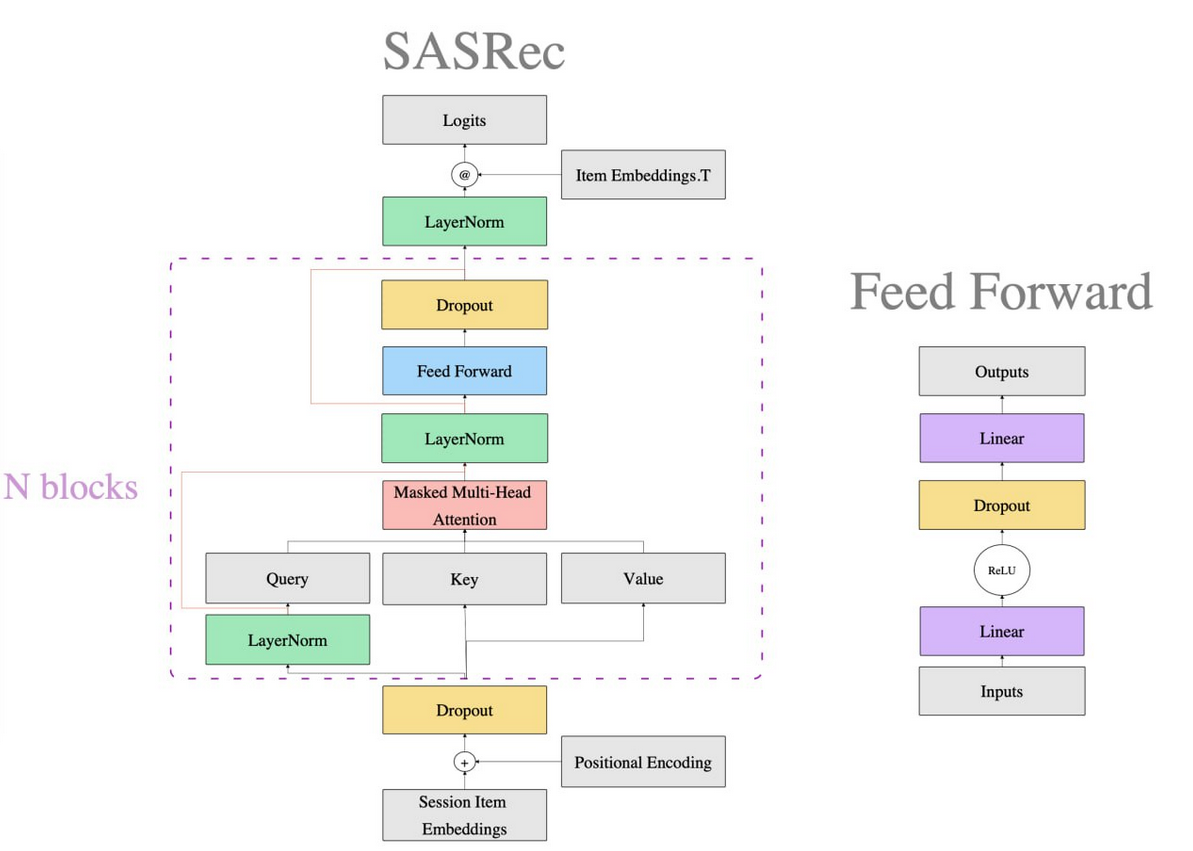

In contrast to BERT4Rec, SASRec is a causal model. It applies causal mask to enforce model focus solely on past interactions.

Uni-directional attention is implemented using a causal mask, which prevents model looking in the future.

### BERT4Rec

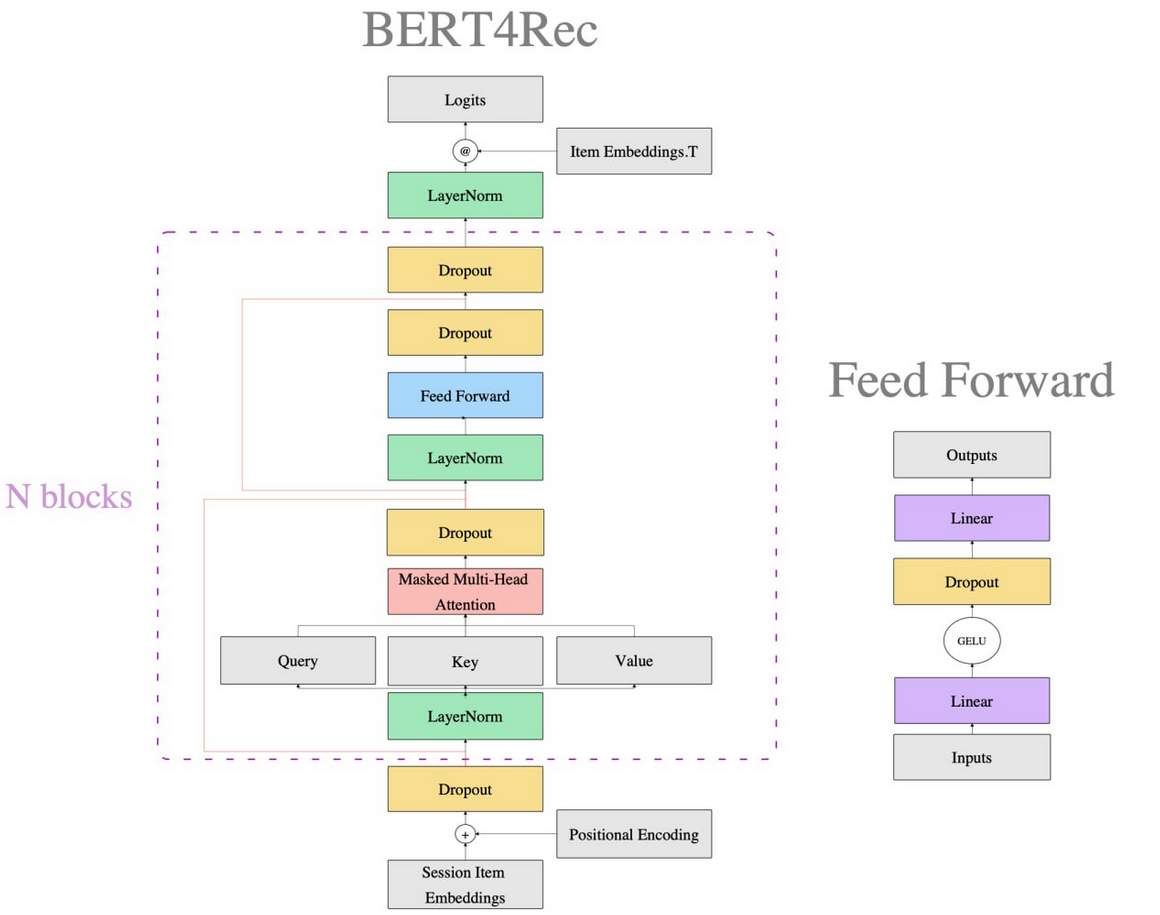

Bi-directional attention. In attention only padding mask is used, which masks padding elements not to allow them affect the results.

### Additional details
1. Xavier normal initialization for model parameters
2. Adam optimizer with betas=(0.9, 0.98)


# Losses
### Softmax loss
Softmax loss is a Cross Entropy loss calculated over the full catalog of items. As softmax loss finds probability distribution across all items, it returns the most precise results, however, for large catalogs such calculations are prohibitively inefficient. 

RecTools implementation uses `torch.nn.CrossEntropyLoss` with 'none' reduction
$$L = \{l_1, l_2, ..., l_N\}^T$$ 
$$l_n = -w_{y_n} log \frac{exp(x_{n,y_n})}{\sum_{c=1}^Cexp(x_{n,c})} \cdot I\{y_n \neq \text{ignore index}\}$$
After that 'sum' reduction is applied, excluding padding elements.
## Losses with negative sampling
Losses with negative sampling are needed to deal with the problem of computational inefficiency inherent to usage of full catalog. For that n negative items per positive are sampled and used for calculations.

RecTools implementation samples negatives uniformly from training dataset.
### BCE loss
Binary Cross Entropy loss aims to improve computational efficiency by using a few sampled negatives instead of the full catalog for calculations. The problem is that in most cases performance degrades.

Logits $(x_n)$ - concat positive and negative logits.

Target $(y_n)$ - positive samples are marked as 1, negative as 0.

RecTools implementation uses `torch.nn.BCEWithLogitsLoss` with 'none' reduction
$$L = \{l_1, l_2, ..., l_N\}^T$$ 
$$l_n = -w_{y_n} [y_n log\sigma (x_n) + (1 - y_n) log(1 - \sigma (x_n))]$$
After that 'sum' reduction is applied, excluding padding elements.

### gBCE loss
Models trained with negative sampling (BCE loss) tend to overestimate probabilities of positive interactions. To mitigate this effect gBCE loss can be used, which is actually BCE loss applied to transformed logits. It combines efficiency of BCE loss with better performance results.

Logit transformation is applied to positive logits only, negative logits remain unchanged:

$$ \text{transformed positive logits} = log(\frac{1}{\sigma^{-\beta}(s^+) - 1})$$
$$\beta = \alpha(t(1-\frac{1}{\alpha}) + \frac{1}{\alpha})$$
$$\alpha = \frac{1}{\text{number of unique items} - 1}$$
$$t - \text{calibration hyperparameter}$$

After that BCE loss is applied to concatenation of transformed positive logits and negative logits.

# Links
1. Transformers: [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

### SASRec
1. SASRec original paper: [Self-Attentive Sequential Recommendation](https://arxiv.org/abs/1808.09781)
2. [Turning Dross Into Gold Loss: is BERT4Rec really better than SASRec?](https://arxiv.org/abs/2309.07602)
3. [gSASRec: Reducing Overconfidence in Sequential Recommendation Trained with Negative Sampling](https://arxiv.org/pdf/2308.07192)

### BERT4Rec
1. BERT4Rec original paper: [BERT4Rec: Sequential Recommendation with Bidirectional Encoder Representations from Transformer](https://arxiv.org/abs/1904.06690)
2. Comparison of BERT4Rec implementations: [A Systematic Review and Replicability Study of BERT4Rec for
Sequential Recommendation](https://arxiv.org/abs/2207.07483)